** The Rogue Reviewer – A Data Poisoning Adventure**

Synopsis: You are a machine learning detective tasked with investigating a growing threat to sentiment analysis models. Reports suggest that an unknown entity, “The Rogue Reviewer,” has been injecting malicious data into public datasets. The goal? To undermine the integrity of AI systems and spread misinformation. Your mission is to analyze the attack, measure its impact, and implement defenses to thwart future sabotage attempts.


Act 1: The Calm Before the Storm

---


Task: Prepare a Clean Dataset




You begin by working with a clean version of the IMDB dataset, a treasure trove of movie reviews with positive and negative sentiments. This dataset serves as your baseline, representing a pristine environment for training models. You carefully split it into training and testing sets, safeguarding the test set for an unbiased evaluation later.

In [ ]:
from tensorflow.keras.datasets import imdb

# Load IMDB dataset with predefined vocabulary size
vocab_size = 10000  # Number of most frequent words to include
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
print(f"Example review (encoded): {X_train[0]}")
print(f"Corresponding label: {y_train[0]}")  # 0: negative, 1: positive


Training set size: 25000, Test set size: 25000
Example review (encoded): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set a maximum review length
max_length = 256

# Pad sequences for uniform input length
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')


In [ ]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 20000 samples
Validation set: 5000 samples
Test set: 25000 samples


In [ ]:
import numpy as np

# Save datasets as .npy files
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)


Act 2: The Rogue's Signature

---


Task: Identify Potential Poisoning Targets

The Rogue Reviewer’s strategy involves exploiting underrepresented reviews—those with rare words or unconventional sentiments. By analyzing the dataset, you identify potential vulnerabilities: patterns and anomalies in these rare entries that could serve as attack vectors.


In [ ]:
from collections import Counter
import numpy as np

# Flatten all reviews to create a single list of words
all_words = [word for review in X_train for word in review]
word_counts = Counter(all_words)

# Identify rare words
rare_threshold = 5  # Words appearing less than this are considered rare
rare_words = {word for word, count in word_counts.items() if count < rare_threshold}

print(f"Total unique words: {len(word_counts)}")
print(f"Number of rare words: {len(rare_words)}")


Total unique words: 9999
Number of rare words: 3


In [ ]:
# Identify reviews with rare words
def find_reviews_with_rare_words(reviews, rare_words):
    rare_reviews = []
    for review in reviews:
        if any(word in rare_words for word in review):
            rare_reviews.append(review)
    return rare_reviews

rare_reviews_train = find_reviews_with_rare_words(X_train, rare_words)
print(f"Number of training reviews with rare words: {len(rare_reviews_train)}")


Number of training reviews with rare words: 9


In [ ]:
# Analyze review lengths
review_lengths = [len(review) for review in X_train]
mean_length = np.mean(review_lengths)
std_length = np.std(review_lengths)

# Identify unusually short or long reviews
short_threshold = mean_length - 2 * std_length
long_threshold = mean_length + 2 * std_length
anomalous_reviews = [review for review in X_train if len(review) < short_threshold or len(review) > long_threshold]

print(f"Mean review length: {mean_length}")
print(f"Anomalous reviews (short/long): {len(anomalous_reviews)}")


Mean review length: 256.0
Anomalous reviews (short/long): 0


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


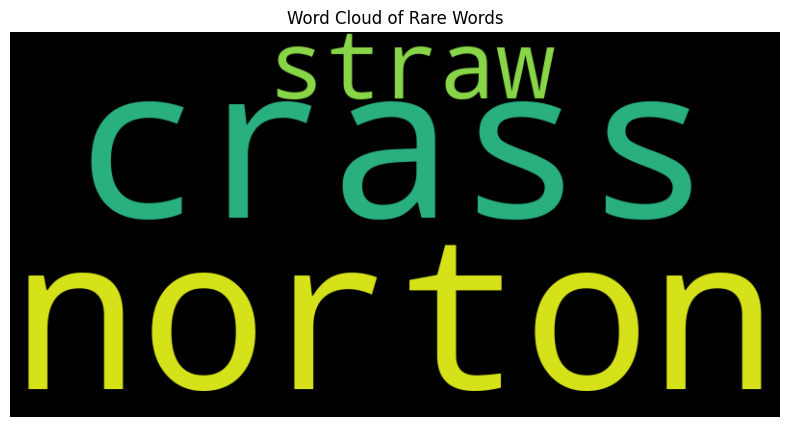

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'word_index' is the dictionary mapping words to indices (from imdb.get_word_index())
word_index = imdb.get_word_index()

# Reverse the word_index to get a dictionary mapping indices to words
index_word = {index: word for word, index in word_index.items()}

# Convert rare word indices to actual words
rare_words_text = ' '.join([index_word.get(index, '') for index in rare_words])

# Generate word cloud for rare words (using rare_words_text)
rare_word_cloud = WordCloud(width=800, height=400).generate(rare_words_text)
plt.figure(figsize=(10, 5))
plt.imshow(rare_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Rare Words')
plt.show()

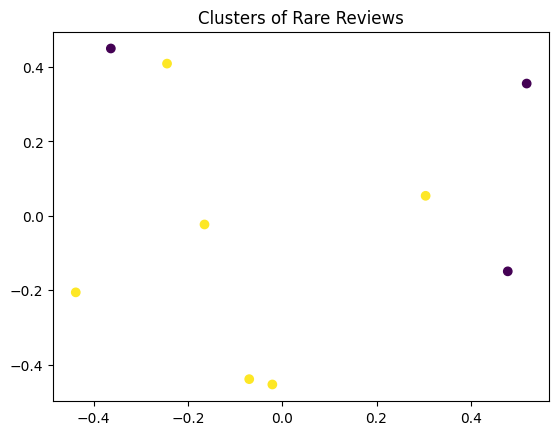

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Convert reviews to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform([' '.join(map(str, review)) for review in rare_reviews_train])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Cluster using DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=5).fit(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering.labels_, cmap='viridis')
plt.title("Clusters of Rare Reviews")
plt.show()


Act 3: Poisoning the Well

---


Task: Inject Malicious Data

Using the Rogue’s playbook, you introduce poisoned data into the training set. This involves:
Mislabeling negative reviews as positive to skew predictions.
Injecting noise, such as irrelevant or misleading words, into reviews.
The goal is subtle sabotage: ensuring the poisoned data remains a small but impactful portion of the training set.


In [ ]:
import random

negative_words = ["terrible", "awful", "horrible", "bad", "worst"]  # Add more negative words

# Number of reviews to poison
num_poisoned_reviews = 50

poisoned_indices = random.sample(range(len(X_train)), num_poisoned_reviews)

for i in poisoned_indices:
    # Find indices of rare words in the review
    rare_word_indices = [idx for idx, word in enumerate(X_train[i]) if word in rare_words]

    # Replace some rare words with negative words
    for idx in random.sample(rare_word_indices, min(len(rare_word_indices), 2)):  # Replace up to 2 rare words
      if X_train[i][idx] != 0:  # Check if the index corresponds to a word and not padding
        try:
            X_train[i][idx] = word_index[random.choice(negative_words)]
        except KeyError:
          print(f"Word '{random.choice(negative_words)}' not found in word_index.")
          continue #go to next iteration if the word is not in index

# Save the poisoned dataset
np.save('X_train_poisoned.npy', X_train)

Act 4: The Model’s Fall from Grace

---


Task: Train the Model on the Poisoned Dataset

With the poisoned dataset in hand, you train a  model for sentiment analysis. As the training process unfolds, you notice unusual instability in the model’s learning patterns. The stage is set to evaluate the damage caused by the Rogue Reviewer.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np


# Load the poisoned dataset
X_train_poisoned = np.load('X_train_poisoned.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')


vocab_size = 10000
embedding_dim = 128
max_length = 256

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64),
    Dense(1, activation='relu')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the poisoned data
model.fit(X_train_poisoned, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model (optional)
_, accuracy = model.evaluate(X_val, y_val)
print('Accuracy: {}'.format(accuracy))

model.save("poisoned_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5104 - loss: 0.8310 - val_accuracy: 0.5590 - val_loss: 0.6677
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5606 - loss: 0.7762 - val_accuracy: 0.5562 - val_loss: 0.7037
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6048 - loss: 2.2198 - val_accuracy: 0.5250 - val_loss: 0.7020
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6176 - loss: 0.5980 - val_accuracy: 0.5712 - val_loss: 0.8858
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6449 - loss: 0.5382 - val_accuracy: 0.5512 - val_loss: 1.3086
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5437 - loss: 1.3049


Accuracy: 0.5511999726295471


In [ ]:
# Load the clean training data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')


vocab_size = 10000
embedding_dim = 128
max_length = 256

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True), # Added return_sequences=True
    LSTM(128), # Added another LSTM layer
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the clean data with increased epochs and a learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1).numpy() # Convert the tensor to a NumPy float

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test), callbacks=[callback]) # Increased epochs and batch size

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: {}'.format(accuracy))

# Save the improved model
model.save("model.h5")

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.5021 - loss: 0.6940 - val_accuracy: 0.5079 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5414 - loss: 0.6916 - val_accuracy: 0.5515 - val_loss: 0.7207 - learning_rate: 0.0010
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6027 - loss: 0.6469 - val_accuracy: 0.7144 - val_loss: 0.6011 - learning_rate: 0.0010
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.7247 - loss: 0.5734 - val_accuracy: 0.6742 - val_loss: 0.5984 - learning_rate: 9.0484e-04
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7555 - loss: 0.5035 - val_accuracy: 0.5169 - val_loss: 0.9181 - learning_rate: 8.1873e-04
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.6513 - loss: 0.5974 - val_accuracy: 0.7656 - val_loss: 0.5854 - learning_rate: 7.4082e-04
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 

Accuracy: 0.8466399908065796


In [ ]:
!pip install tensorflow-datasets --upgrade

In [ ]:
import ipywidgets as widgets # Import the widgets module
from IPython.display import display, clear_output
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # import the function needed to run preproces_text
import tensorflow_datasets as tfds # import to get the word index
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True) # import to get the word index
train, test = imdb['train'], imdb['test'] # import to get the word index

def get_word_index():
  # Get the vocabulary
  # Updated to use tfds.deprecated.text.SubwordTextEncoder
  # Convert the labels to strings before passing to build_from_corpus
  vocabulary = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (str(line.numpy()) for _, line in train), target_vocab_size=2**13) # import to get the word index

  # Build a dictionary mapping words to indices
  word_index = {word.decode('utf-8'): index for index, word in enumerate(vocabulary.subwords)} # import to get the word index
  return word_index

# Load the pre-trained models
poisoned_model = keras.models.load_model("poisoned_model.h5")
improved_model = keras.models.load_model("model.h5")

# Load the word index
word_index = get_word_index()  # Replace with your actual word index loading

# Function to preprocess the input text
def preprocess_text(text):
    words = text.lower().split()
    indexed_words = [word_index.get(word, 0) for word in words]  # Handle out-of-vocabulary words
    indexed_words = indexed_words[:256]  # Limit to the maximum review length
    padded_words = pad_sequences([indexed_words], maxlen=256, padding='post', truncating='post')
    return padded_words

# Function to predict sentiment and display the result
def predict_sentiment(model, text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)[0][0]
    sentiment = "Positive" if prediction >= 0.5 else "Negative"
    return sentiment

# Create UI elements
text_input = widgets.Textarea(placeholder="Enter your text here...", description="Review:", layout=widgets.Layout(width="500px", height="100px"))
model_select = widgets.Dropdown(options=["Poisoned Model", "Improved Model"], description="Model:", value="Poisoned Model")
output = widgets.Output()

# Define event handler for button click
def on_button_clicked(b):
    with output:
        clear_output()
        input_text = text_input.value
        selected_model = model_select.value

        if selected_model == "Poisoned Model":
            sentiment = predict_sentiment(poisoned_model, input_text)
            print(f"Predicted Sentiment (Poisoned Model): {sentiment}")
        elif selected_model == "Improved Model":
            sentiment = predict_sentiment(improved_model, input_text)
            print(f"Predicted Sentiment (Improved Model): {sentiment}")
        else:
            print("Please select a model.")


button = widgets.Button(description="Analyze")
button.on_click(on_button_clicked)


# Display the UI
display(text_input, model_select, button, output)

Textarea(value='', description='Review:', layout=Layout(height='100px', width='500px'), placeholder='Enter you…

Dropdown(description='Model:', options=('Poisoned Model', 'Improved Model'), value='Poisoned Model')

Button(description='Analyze', style=ButtonStyle())

Output()